In [1]:
import pandas as pd
from datetime import datetime, timedelta
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/javier/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
df = pd.read_csv('2020 - Semana 1 (05012020).txt',error_bad_lines=False,encoding = 'unicode_escape', 
                 header=3, sep='\t', skiprows=[4], skipinitialspace=True, 
                 usecols=['Descripción','Título/Descripción', 'Cadena', 'Fecha', 'Género','Público objetivo', 
                          'Productora','Calificación de Edad','Ind. 4+ (inv)','Amas de Casa (c/inv.)'
                          ,'Ind. 4 - 12 (c/inv.)', 'Ind. 16+ (c/inv.)','Ind. 4+ (inv).1','Amas de Casa (c/inv.).1',
                          'Ind. 4 - 12 (c/inv.).1', 'Ind. 16+ (c/inv.).1'])

#ELIMINAMOS LAS CABECERAS DE LOS PROGRAMAS EN LA COLUMNA DESCRIPCIÓN
df.dropna(inplace = True)
df = df[df.Descripción.str.startswith('<<')]
df.reset_index(drop = True,inplace = True)

#ELIMINAMOS LOS SIMBOLOS <> DEL DATA FRAME
df1 = pd.DataFrame()
for i in df.columns:
    df1 = pd.concat([df1,df.loc[:,str(i)].str.translate({ord(x): None for x in ('><')})], axis = 1)
    
#DIVIDIMOS LA COLUMNA EN DOS PARA PODER OPERAR SOLO CON LA HORA 
#(NO SE PUEDE PASAR A DATETIME YA QUE NO ESTÁ EN EL RANGO ADECUADO)
df1[['Hora','Minuto']] = df1.Descripción.str.split(':', expand = True)
df1.head(5)

#PASAMOS LA COLUMNA FECHA A DATETIME PARA PODER RESTAR DIAS CUANDO SEA NECESARIO
df1['Fecha'] = pd.to_datetime(df1['Fecha'],format = "%d/%m/%Y", dayfirst=True)
df1.dtypes

#SE CAMBIA EL TIPO DE DATO EN LAS COLUMNAS HORA MINUTO PARA PODER TRANSFORMAR A RANGO 00:00-23:00(STR-INT)
df1 = df1.astype({'Hora':'int','Minuto':'int'})
df1.dtypes

#SE RESTA DOS HORAS PARA TENER RANGO 00-24
df1.Hora = df1['Hora'].map(lambda value : value - 2)

#SUMAMOS 1 DÍA A LAS HORAS SUPERIORES A 23
ind = df1[df1['Hora']>23].index
df1.loc[ind,'Fecha']= df1.loc[ind,'Fecha'] + timedelta(days=1)

#SE SUSTITUYE EL 24 POR 0 PARA TENER RANGO 00-23
df1.Hora = df1.Hora.replace(24,0)


#CONVIERTO LA FECHA A STRING PARA PODER UNIRLO CON LA HORA
df1['Fecha']=df1.Fecha.apply(lambda x:str(x.date()))
df1[df1['Cadena']=='La1'].head(1413)

#VOLVEMOS A CONVERTIR HORA Y MINUTO A STR PARA PODER UNIRLOS CON ':' COMO SEPARADOR
df1 = df1.astype({'Hora':'str', 'Minuto':'str'})

#UNIMOS HORA Y MINUTO PARA DESPUÉS UNIRLO A LA FECHA Y CONVERTIRLO EN TIMESTAMP
df1 ['Tiempo'] = df1[['Hora', 'Minuto']].apply(lambda x: ':'.join(x), axis=1)
df1 ['Fecha_comp'] = df1[['Fecha', 'Tiempo']].apply(lambda x: ' '.join(x), axis=1)
df1.Fecha_comp = pd.to_datetime(df1.Fecha_comp)

#ELIMINAMOS LAS COLUMNAS GENERADAS Y USADAS PARA LAS TRANSFORMACIONES
df1 = df1.drop(['Tiempo','Hora', 'Minuto','Fecha','Descripción'], axis = 1)
#,'Descripción'

#CAMBIO COMA POR PUNTO PARA PODER CONVERTIR A ARRAY DE FLOAT
column = ['Ind. 4+ (inv)','Amas de Casa (c/inv.)', 'Ind. 4 - 12 (c/inv.)','Ind. 16+ (c/inv.)',
          'Ind. 4+ (inv).1','Amas de Casa (c/inv.).1','Ind. 4 - 12 (c/inv.).1', 'Ind. 16+ (c/inv.).1']
for i in column:
    df1[i]=df1[i].str.replace(',','.')
    
#CREO LA VARIABLE TARGET CON LAS COLUMNAS NECESARIAS
df1['Target']= df1[column].apply(lambda x:'/'.join(x),axis=1)
df1['Target']= df1.Target.str.split('/').apply(lambda x:np.array(x,dtype=np.float32))

#ELIMINAMOS LAS VARIABLES UTILIZADAS EN TARGET
df1 = df1.drop(column,axis = 1)

#ELIMINAMOS TITULO/DESCRIPCION DE MOMENTO (!)
#df1 = df1.drop('Título/Descripción',axis = 1)

#ORDENO LAS COLUMNAS DE MI DATA FRAME (!) 
df1 = df1[['Fecha_comp','Título/Descripción','Cadena', 'Género', 'Público objetivo', 'Productora',
       'Calificación de Edad', 'Target']]

#ELIMINO CADENAS REGIONALES, YA QUE BUSCO ESTIMACIONES A NIVEL NACIONAL
regionales = ['C.SUR', 'TV3', 'ETB1', 'ETB2', 'TVG',
     'TELEMADRID', 'CSUR-AND', 'TVCAN', 'ETB4', 'CMM', '8TV',
      'ETB3', 'LAOTRA', 'TPA2', 'ARAGON TV', 'TPA', 'IB3',
      'LA 7TV', 'TVG2', 'La 7', 'SUPER3/33', 'TV MEDITERRANEO', 'AND-TV',
      'A PUNT', '8MADRID','3/24','BOM Cine']
df1 = df1[~df1['Cadena'].isin(regionales)]

In [4]:
X = df1.drop(['Target','Fecha_comp'], axis=1)
y = df1.Target
cop = pd.get_dummies(X, prefix_sep='_', drop_first=True)

In [7]:
cop.head()

,Cadena_#VAMOS,Cadena_24H,Cadena_3/24,Cadena_8MADRID,Cadena_8TV,Cadena_A PUNT,Cadena_A3,Cadena_AMC,Cadena_AND-TV,Cadena_ARAGON TV,...,Calificación de Edad_+13 años permanente,Calificación de Edad_+16 años no permanente,Calificación de Edad_+16 años permanente,Calificación de Edad_+18 años no permanente,Calificación de Edad_+18 años permanente,Calificación de Edad_+7 años,Calificación de Edad_Especial Infancia,Calificación de Edad_Sin Clasificar,Calificación de Edad_Sin Preaviso,Calificación de Edad_Todos los Públicos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
# Load the library
from sklearn.tree import DecisionTreeRegressor
# Create an instance
regd = DecisionTreeRegressor(max_depth=3)
# Fit the data
cross_val_score(regd, cop, y)

/home/javier/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
AttributeError: 'bool' object has no attribute 'any'

  FitFailedWarning)
/home/javier/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
AttributeError: 'bool' object has no attribute 'any'

  FitFailedWarning)
/home/javier/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
AttributeError: 'bool' object has no attribute 'any'

  FitFailedWarning)
/home/javier/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFaile

array([nan, nan, nan, nan, nan])

In [3]:
#ANALIZAMOS CUANTAS DESCONEXIONES REGIONALES CONTIENE CADA CADENA
df1[df1['Título/Descripción'].str.contains('D.REG')].pivot_table(index=['Cadena'], aggfunc='size').sort_values(ascending=False)

Cadena
La2     367
La1     239
T5        9
A3        9
NOVA      7
dtype: int64

In [4]:
#CUENTO DUPLICADOS PARA CADA CADENA
counter = 1
for i in df1.Cadena.unique():
    print(counter)
    print(i,'-----', df1[df1['Cadena'] == i ].pivot_table(index=['Fecha_comp'], aggfunc='size').unique())
    counter += 1

1
La1 ----- [ 1  2 15 16 17  3 18  4]
2
La2 ----- [1 2 3 5 4]
3
T5 ----- [1 2 3]
4
A3 ----- [1 2 3 4]
5
CUATRO ----- [1]
6
LA SEXTA ----- [1 2]
7
24H ----- [1 2 3]
8
NEOX ----- [1 2]
9
NOVA ----- [1 2 3 4 5]
10
AXN ----- [1]
11
BARÇA TV ----- [1 2]
12
BLAZE ----- [1]
13
HISTORIA ----- [1 2 3]
14
MOVISTAR ACCION ----- [1]
15
MOVISTAR COMEDIA ----- [1]
16
MOVISTAR DRAMA ----- [1]
17
MOVISTAR DEPORTES ----- [2 1 3]
18
CALLE 13 ----- [1]
19
CANAL COCINA ----- [1]
20
CANAL HOLLYWOOD ----- [1]
21
CAZA Y PESCA ----- [1]
22
SUNDANCE TV ----- [1 2]
23
CLAN ----- [1 2]
24
COSMOPOLITAN ----- [1 2]
25
DARK ----- [1 2]
26
MOVISTAR CINE ESPAÑOL ----- [1]
27
DECASA ----- [1 2 3]
28
DISCOVERY ----- [1 2]
29
DISNEY CH +1 ----- [1 2]
30
DISNEY CHANNEL ----- [1 2]
31
EUROSPORT ----- [1 2]
32
XTRM ----- [1 2]
33
FDF ----- [1 2]
34
FOX ----- [1]
35
MOVISTAR GOLF ----- [1 2]
36
MTV ESP ----- [1 2 3]
37
NATIONAL GEOGRAPHIC ----- [1]
38
NICKELODEON ----- [1 2]
39
ODISEA ----- [1 2]
40
PANDA ----- [1 2]
41
COM

In [105]:
pd.set_option('display.max_rows', None)
df1[df1['Cadena'] == 'REAL MADRID HD'].pivot_table(index=['Fecha_comp'], aggfunc='size').sort_values(ascending=False)

Fecha_comp
2020-01-01 04:17:00    3
2020-01-04 10:47:00    3
2020-01-02 12:33:00    3
2020-01-02 12:32:00    3
2020-01-02 12:31:00    3
2020-01-02 12:30:00    3
2020-01-04 01:12:00    3
2020-01-02 12:26:00    3
2020-01-03 00:05:00    3
2020-01-01 06:07:00    3
2020-01-05 13:57:00    3
2020-01-02 04:27:00    3
2020-01-03 06:11:00    3
2020-01-01 01:31:00    3
2020-01-02 08:16:00    3
2020-01-01 11:58:00    3
2020-01-03 01:49:00    3
2020-01-02 12:34:00    3
2020-01-01 11:08:00    3
2020-01-01 01:09:00    3
2020-01-01 11:07:00    3
2020-01-02 06:10:00    3
2020-01-03 04:27:00    3
2020-01-03 10:28:00    3
2020-01-02 23:07:00    3
2020-01-01 10:33:00    3
2020-01-01 09:16:00    3
2020-01-04 00:22:00    3
2020-01-01 10:49:00    3
2020-01-01 08:56:00    3
2020-01-02 01:03:00    3
2020-01-04 18:29:00    3
2020-01-01 23:10:00    3
2020-01-01 23:09:00    3
2020-01-03 22:32:00    3
2020-01-01 03:23:00    3
2020-01-04 08:49:00    3
2020-01-01 09:55:00    3
2020-01-03 12:34:00    3
2020-01-03 12:

In [118]:
df1[df1['Target'] == [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]].headd()

ValueError: Lengths must match to compare

In [115]:
df1.Target[0]

array([2.764000e+00, 3.066000e+00, 8.800000e-01, 2.992000e+00,
       1.245629e+03, 5.697780e+02, 3.776900e+01, 1.176382e+03],
      dtype=float32)

In [107]:
df1[(df1['Fecha_comp']== pd.to_datetime('2020-01-03 14:19:00')) & (df1['Cadena']== 'REAL MADRID HD')]

,Fecha_comp,Título/Descripción,Cadena,Género,Público objetivo,Productora,Calificación de Edad,Target
456649,2020-01-03 14:19:00,CINE / MADISON,REAL MADRID HD,FICCIÓN,FAMILIAR,MULTIPRODUCTORA,Todos los Públicos,"[0.08, 0.094, 0.0, 0.092, 36.059, 17.385, 0.0,..."


In [81]:
df1[(df1['Título/Descripción'].str.contains('D.REG'))&(df1['Cadena']=='La1')].pivot_table(index=['Fecha_comp'], aggfunc='size')

Fecha_comp
2020-01-02 11:59:00    1
2020-01-02 12:00:00    1
2020-01-02 12:01:00    1
2020-01-02 12:02:00    1
2020-01-02 12:03:00    1
2020-01-02 12:04:00    1
2020-01-02 12:05:00    1
2020-01-02 12:06:00    1
2020-01-02 12:07:00    1
2020-01-02 12:08:00    1
2020-01-02 12:09:00    1
2020-01-02 12:10:00    1
2020-01-02 12:11:00    1
2020-01-02 12:12:00    1
2020-01-02 12:13:00    1
2020-01-02 12:14:00    1
2020-01-02 12:15:00    1
2020-01-02 12:16:00    1
2020-01-02 12:17:00    1
2020-01-02 12:18:00    1
2020-01-02 12:19:00    1
2020-01-02 12:20:00    1
2020-01-02 12:21:00    1
2020-01-02 12:22:00    1
2020-01-02 12:23:00    1
2020-01-02 12:24:00    1
2020-01-02 12:25:00    1
2020-01-02 12:26:00    1
2020-01-02 14:00:00    1
2020-01-02 14:01:00    1
2020-01-02 14:02:00    1
2020-01-02 14:03:00    1
2020-01-02 14:04:00    1
2020-01-02 14:05:00    1
2020-01-02 14:06:00    1
2020-01-02 14:07:00    1
2020-01-02 14:08:00    1
2020-01-02 14:09:00    1
2020-01-02 14:10:00    1
2020-01-02 14:

In [82]:
df1[df1['Cadena'] == 'A3'].pivot_table(index=['Fecha_comp'], aggfunc='size').sort_values(ascending=False)

Fecha_comp
2020-01-04 05:00:00    4
2020-01-05 05:11:00    4
2020-01-05 06:09:00    4
2020-01-04 04:59:00    4
2020-01-04 04:58:00    4
2020-01-05 05:09:00    4
2020-01-05 05:12:00    4
2020-01-05 05:10:00    4
2020-01-02 21:26:00    3
2020-01-05 13:48:00    3
2020-01-05 06:03:00    3
2020-01-03 17:21:00    3
2020-01-01 12:05:00    2
2020-01-01 12:07:00    2
2020-01-05 06:29:00    2
2020-01-01 12:06:00    2
2020-01-02 11:11:00    2
2020-01-05 08:23:00    2
2020-01-05 06:27:00    2
2020-01-01 12:03:00    2
2020-01-01 12:01:00    2
2020-01-05 08:21:00    2
2020-01-02 15:37:00    2
2020-01-04 07:55:00    2
2020-01-01 08:03:00    2
2020-01-04 07:54:00    2
2020-01-01 08:05:00    2
2020-01-05 06:28:00    2
2020-01-01 12:08:00    2
2020-01-05 06:26:00    2
2020-01-05 06:25:00    2
2020-01-03 15:34:00    2
2020-01-03 15:35:00    2
2020-01-03 15:36:00    2
2020-01-02 11:20:00    2
2020-01-02 11:21:00    2
2020-01-02 11:22:00    2
2020-01-02 11:23:00    2
2020-01-05 08:24:00    2
2020-01-01 12:

In [44]:
pd.set_option('display.max_rows', None)
df1[(df1['Título/Descripción'].str.contains('D.REG'))&(df1['Cadena']== 'La1')].pivot_table(index=['Fecha_comp'], aggfunc='size').sort_values(ascending=False)

Fecha_comp
2020-01-05 18:59:00    1
2020-01-03 12:20:00    1
2020-01-03 14:06:00    1
2020-01-03 14:05:00    1
2020-01-03 14:04:00    1
2020-01-03 14:03:00    1
2020-01-03 14:02:00    1
2020-01-03 14:01:00    1
2020-01-03 12:26:00    1
2020-01-03 12:25:00    1
2020-01-03 12:24:00    1
2020-01-03 12:23:00    1
2020-01-03 12:22:00    1
2020-01-03 12:21:00    1
2020-01-03 12:19:00    1
2020-01-03 14:08:00    1
2020-01-03 12:18:00    1
2020-01-03 12:17:00    1
2020-01-03 12:16:00    1
2020-01-03 12:15:00    1
2020-01-03 12:14:00    1
2020-01-03 12:13:00    1
2020-01-03 12:12:00    1
2020-01-03 12:11:00    1
2020-01-03 12:10:00    1
2020-01-03 12:09:00    1
2020-01-03 12:08:00    1
2020-01-03 12:07:00    1
2020-01-03 14:07:00    1
2020-01-03 14:09:00    1
2020-01-03 12:05:00    1
2020-01-03 14:29:00    1
2020-01-05 13:57:00    1
2020-01-05 13:56:00    1
2020-01-05 13:55:00    1
2020-01-05 13:54:00    1
2020-01-05 13:53:00    1
2020-01-05 13:52:00    1
2020-01-04 13:59:00    1
2020-01-04 13:

In [38]:
df1[(df1['Título/Descripción'].str.contains('D.REG'))&(df1['Cadena']== 'La1')]

,Fecha_comp,Título/Descripción,Cadena,Género,Público objetivo,Productora,Calificación de Edad,Target
158409,2020-01-02 11:59:00,D.REG(INFORMATIVO TERRITORIAL 1),La1,INFORMACIÓN,FAMILIAR,RTVE,Sin Preaviso,"[0.828, 1.263, 0.33, 0.902, 373.045, 234.758, ..."
158410,2020-01-02 12:00:00,D.REG(INFORMATIVO TERRITORIAL 1),La1,INFORMACIÓN,FAMILIAR,RTVE,Sin Preaviso,"[0.811, 1.228, 0.33, 0.883, 365.429, 228.224, ..."
158411,2020-01-02 12:01:00,D.REG(INFORMATIVO TERRITORIAL 1),La1,INFORMACIÓN,FAMILIAR,RTVE,Sin Preaviso,"[0.884, 1.349, 0.33, 0.968, 398.641, 250.693, ..."
158412,2020-01-02 12:02:00,D.REG(INFORMATIVO TERRITORIAL 1),La1,INFORMACIÓN,FAMILIAR,RTVE,Sin Preaviso,"[0.967, 1.509, 0.471, 1.047, 436.025, 280.46, ..."
158413,2020-01-02 12:03:00,D.REG(INFORMATIVO TERRITORIAL 1),La1,INFORMACIÓN,FAMILIAR,RTVE,Sin Preaviso,"[1.024, 1.574, 0.471, 1.112, 461.611, 292.53, ..."
...,...,...,...,...,...,...,...,...
627925,2020-01-05 18:55:00,D.REG(CABALGATA DE REYES),La1,ENTRETENIMIENTO,FAMILIAR,RTVE,Sin Preaviso,"[3.433, 4.205, 1.912, 3.671, 1547.191, 781.398..."
627926,2020-01-05 18:56:00,D.REG(CABALGATA DE REYES),La1,ENTRETENIMIENTO,FAMILIAR,RTVE,Sin Preaviso,"[3.335, 4.111, 1.912, 3.559, 1503.307, 763.967..."
627927,2020-01-05 18:57:00,D.REG(CABALGATA DE REYES),La1,ENTRETENIMIENTO,FAMILIAR,RTVE,Sin Preaviso,"[3.372, 4.078, 1.976, 3.589, 1519.707, 757.724..."
627928,2020-01-05 18:58:00,D.REG(CABALGATA DE REYES),La1,ENTRETENIMIENTO,FAMILIAR,RTVE,Sin Preaviso,"[3.455, 4.145, 1.892, 3.694, 1557.327, 770.328..."


In [37]:
print(len(df1.loc[632225,'Target']))
print(len(df1.loc[632802,'Target']))

8
8


In [76]:
df1[(df1['Fecha_comp']== pd.to_datetime('2020-01-02 16:17:00')) & (df1['Cadena']== 'La2')]

,Fecha_comp,Título/Descripción,Cadena,Género,Público objetivo,Productora,Calificación de Edad,Target
160878,2020-01-02 16:17:00,D.REG(DOCUMENTA2),La2,CULTURALES,FAMILIAR,RTVE,Sin Preaviso,"[0.927, 1.19, 0.054, 1.035, 417.722, 221.13, 2..."
160921,2020-01-02 16:17:00,PATER(ANTONI VIVES FIERRO),La2,CULTURALES,FAMILIAR,OTRAS PRODUCTORAS INDEPENDIENTES,Sin Preaviso,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
160964,2020-01-02 16:17:00,DOCUMENTA2,La2,CULTURALES,FAMILIAR,RTVE,Sin Preaviso,"[0.927, 1.19, 0.054, 1.035, 417.722, 221.13, 2..."
161006,2020-01-02 16:17:00,D.REG(EL MARAVILLOSO MUNDO DE LOS CACHORROS),La2,CULTURALES,FAMILIAR,MULTIPRODUCTORA,Sin Preaviso,"[0.927, 1.19, 0.054, 1.035, 417.722, 221.13, 2..."
161048,2020-01-02 16:17:00,EL MARAVILLOSO MUNDO DE LOS CACHORROS,La2,CULTURALES,FAMILIAR,MULTIPRODUCTORA,Todos los Públicos,"[0.927, 1.19, 0.054, 1.035, 417.722, 221.13, 2..."


In [55]:
pd.set_option('display.max_rows', None)
df1[df1['Cadena']== 'La2'].pivot_table(index=['Fecha_comp'], aggfunc='size').sort_values(ascending=False)

Fecha_comp
2020-01-02 16:29:00    5
2020-01-02 16:04:00    5
2020-01-02 16:14:00    5
2020-01-02 16:15:00    5
2020-01-02 16:16:00    5
2020-01-02 16:17:00    5
2020-01-02 16:18:00    5
2020-01-02 16:19:00    5
2020-01-02 16:20:00    5
2020-01-02 16:21:00    5
2020-01-02 16:22:00    5
2020-01-02 16:23:00    5
2020-01-02 16:24:00    5
2020-01-02 16:25:00    5
2020-01-02 16:26:00    5
2020-01-02 16:27:00    5
2020-01-05 08:34:00    5
2020-01-05 08:35:00    5
2020-01-05 08:36:00    5
2020-01-05 08:37:00    5
2020-01-05 08:38:00    5
2020-01-05 08:39:00    5
2020-01-05 08:40:00    5
2020-01-02 16:31:00    5
2020-01-02 16:32:00    5
2020-01-02 16:33:00    5
2020-01-02 16:44:00    5
2020-01-02 16:06:00    5
2020-01-02 16:07:00    5
2020-01-02 16:08:00    5
2020-01-02 16:09:00    5
2020-01-02 16:10:00    5
2020-01-02 16:11:00    5
2020-01-02 16:12:00    5
2020-01-02 16:13:00    5
2020-01-02 16:45:00    5
2020-01-02 16:43:00    5
2020-01-02 16:34:00    5
2020-01-02 16:42:00    5
2020-01-02 16:

In [70]:
df1[(df1['Fecha_comp']== pd.to_datetime('2020-01-02 13:28:00')) & (df1['Cadena']== 'La2')]


,Fecha_comp,Título/Descripción,Cadena,Género,Público objetivo,Productora,Calificación de Edad,Target
160625,2020-01-02 13:28:00,LAS NUEVAS MEDIDAS DEL MUNDO,La2,CULTURALES,FAMILIAR,EINE PRODUKTION VON,Todos los Públicos,"[0.338, 0.435, 0.035, 0.373, 152.263, 80.772, ..."


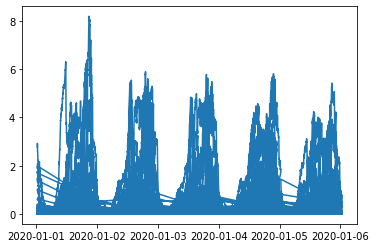

In [34]:
plt.plot(df1.Fecha_comp, df1.Target)

In [15]:
#df1.Fecha_comp.unique()
df1[df1['Cadena']== 'La2'].pivot_table(index=['Fecha_comp'], aggfunc='size').sort_values(ascending=False)

Fecha_comp
2020-01-02 16:29:00    5
2020-01-02 16:04:00    5
2020-01-02 16:14:00    5
2020-01-02 16:15:00    5
2020-01-02 16:16:00    5
                      ..
2020-01-04 02:47:00    1
2020-01-04 02:48:00    1
2020-01-04 02:49:00    1
2020-01-04 02:50:00    1
2020-01-01 00:30:00    1
Length: 7013, dtype: int64

In [44]:
#CREO EL DATA FRAME CON LAS VARIABLES CATEGÓRICAS
df_cat = df1[['Cadena', 'Género', 'Público objetivo', 'Productora','Calificación de Edad']]

In [6]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [9]:
cop = pd.get_dummies(X, prefix_sep='_', drop_first=True)

In [18]:
y_2 = df1.Target[0]

0.88

In [13]:
cop.dtypes.unique()

array([dtype('<M8[ns]'), dtype('uint8')], dtype=object)

In [33]:
reg = LinearRegression()

In [43]:
# Load the library
from sklearn.tree import DecisionTreeRegressor
# Create an instance
regd = DecisionTreeRegressor(max_depth=3)
# Fit the data
cross_val_score(regd, cop, y)

/home/javier/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: invalid type promotion

  FitFailedWarning)


array([nan, nan, nan, nan, nan])